### Final Model - Model 3
In this file we build and train model 3 using the structure mentioned in the report. 

In [1]:
import os
from dotenv import dotenv_values

import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [2]:
#get files from .env file
config = dotenv_values(".env")

In [3]:
# define repetitive values
raw_dir = config['RAW_PATH']

img_dim = int(config['DIM'])
batch_size = int(config['BATCH_SIZE'])
epoch_nbr = int(config['EPOCH'])

input_shape = (img_dim, img_dim, 3)

In [4]:
#in this code we are going to use the segmented dataset as the model's inut

#Paths to segmented data
seg_train_path = raw_dir + '/splitDataset/Segmented/train'
seg_val_path = raw_dir + '/splitDataset/Segmented/val'
seg_test_path = raw_dir + '/splitDataset/Segmented/test'

#### helper functions

In [5]:
# image data generator for train and val datasets
# data augmentation is applied only on the traing dataset

def image_data_generator():
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 20,
                                       horizontal_flip = True,
                                       shear_range=0.2, # shear the image
                                       zoom_range=0.2, # zoom into the image
                                       width_shift_range=0.2, # shift the image width ways
                                       height_shift_range=0.2, # shift the image height ways
                                      )
    
    validation_datagen = ImageDataGenerator(rescale=1/255.)
    return [train_datagen, validation_datagen]

In [6]:
# Plot the validation and training data separately
def plot_loss_curves(history , metric , val_metric):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history[metric]
    val_accuracy = history.history[val_metric]

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

#### build the model

In [7]:
#create data generators
train_datagen, val_datagen = image_data_generator()

In [8]:
# Create segmented data batches
print("\nSegmented data set")
print("Augmented training images:")
seg_train_data = train_datagen.flow_from_directory(seg_train_path,
                                               target_size=(img_dim, img_dim),
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True) 

print("validation images:")
seg_val_data = val_datagen.flow_from_directory(seg_val_path,
                                             target_size=(img_dim, img_dim),
                                             batch_size=batch_size,
                                             class_mode='categorical')


Segmented data set
Augmented training images:
Found 2082 images belonging to 4 classes.
validation images:
Found 649 images belonging to 4 classes.


In [9]:
# feature block

densenet_model = keras.applications.DenseNet201(include_top=False,
                                                weights="imagenet",
                                                input_tensor=None,
                                                input_shape=input_shape,
                                                pooling=None)

In [10]:
# with training case
# By setting the trainable property of this model we created to True,
# we allow the weights in trainable layers to be updated. 

densenet_model.trainable = True
count = 0
for layer in densenet_model.layers:
    if 'conv5' in layer.name:
        count = count + 1
        layer.trainable = True
    else:
        layer.trainable = False

print('nbr of trainable layers = ', count)

nbr of trainable layers =  224


In [11]:
input = keras.Input(shape=input_shape)

layer = densenet_model(inputs=input)

#classification block
layer = keras.layers.Flatten()(layer)

layer = keras.layers.BatchNormalization()(layer)
initializer = keras.initializers.he_normal(seed=32)

layer = keras.layers.Dense(units=256,
                        activation='relu',
                        kernel_initializer=initializer
                        )(layer)

layer = keras.layers.Dropout(0.4)(layer)

layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.Dense(units=128,
                       activation='relu',
                       kernel_initializer=initializer
                       )(layer)

layer = keras.layers.Dropout(0.4)(layer)

layer = keras.layers.Dense(units=4,
                       activation='softmax',
                       kernel_initializer=initializer
                       )(layer)


In [12]:
final_model_densenet201 = keras.models.Model(inputs=input, outputs=layer)
final_model_densenet201.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 94080)             376320    
_________________________________________________________________
dense (Dense)                (None, 256)               24084736  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024  

In [13]:
# compile model
final_model_densenet201.compile(loss='binary_crossentropy',
                                optimizer=keras.optimizers.Adam(),
                                metrics=['accuracy'])

In [14]:
model_history = final_model_densenet201.fit(seg_train_data,
                                            epochs=epoch_nbr,
                                            steps_per_epoch=len(seg_train_data),
                                            validation_data=seg_val_data,
                                            validation_steps=len(seg_val_data))

Epoch 1/100
66/66 [==============================] - 1026s 15s/step - loss: 0.2077 - accuracy: 0.8694 - val_loss: 0.1242 - val_accuracy: 0.9353
Epoch 2/100
66/66 [==============================] - 714s 11s/step - loss: 0.0959 - accuracy: 0.9361 - val_loss: 0.0470 - val_accuracy: 0.9707
Epoch 3/100
66/66 [==============================] - 737s 11s/step - loss: 0.0869 - accuracy: 0.9433 - val_loss: 0.0624 - val_accuracy: 0.9584
Epoch 4/100
66/66 [==============================] - 633s 10s/step - loss: 0.0609 - accuracy: 0.9635 - val_loss: 0.0289 - val_accuracy: 0.9800
Epoch 5/100
66/66 [==============================] - 624s 9s/step - loss: 0.0551 - accuracy: 0.9659 - val_loss: 0.1018 - val_accuracy: 0.9461
Epoch 6/100
66/66 [==============================] - 623s 9s/step - loss: 0.0494 - accuracy: 0.9664 - val_loss: 0.0219 - val_accuracy: 0.9846
Epoch 7/100
66/66 [==============================] - 725s 11s/step - loss: 0.0438 - accuracy: 0.9712 - val_loss: 0.0578 - val_accuracy: 0.9769


66/66 [==============================] - 648s 10s/step - loss: 0.0143 - accuracy: 0.9899 - val_loss: 0.0228 - val_accuracy: 0.9846
Epoch 59/100
66/66 [==============================] - 646s 10s/step - loss: 0.0171 - accuracy: 0.9885 - val_loss: 0.0174 - val_accuracy: 0.9861
Epoch 60/100
66/66 [==============================] - 628s 10s/step - loss: 0.0298 - accuracy: 0.9808 - val_loss: 0.0144 - val_accuracy: 0.9923
Epoch 61/100
66/66 [==============================] - 639s 10s/step - loss: 0.0254 - accuracy: 0.9808 - val_loss: 0.0399 - val_accuracy: 0.9738
Epoch 62/100
66/66 [==============================] - 627s 10s/step - loss: 0.0244 - accuracy: 0.9837 - val_loss: 0.0327 - val_accuracy: 0.9753
Epoch 63/100
66/66 [==============================] - 658s 10s/step - loss: 0.0309 - accuracy: 0.9832 - val_loss: 0.0242 - val_accuracy: 0.9800
Epoch 64/100
66/66 [==============================] - 660s 10s/step - loss: 0.0198 - accuracy: 0.9894 - val_loss: 0.0287 - val_accuracy: 0.9769
Epoch

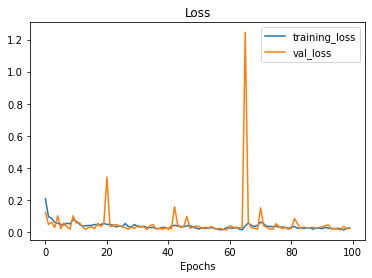

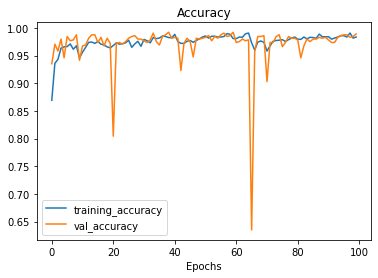

In [15]:
plot_loss_curves(model_history , 'accuracy' , 'val_accuracy')

In [16]:
# Save a model
final_model_densenet201.save("saved_model/final_model.h5")